이번 강의에서는 9장과 10장을 다룹니다. 이제 Tabular 방법을 벗어나 무한한 경우의 수를 다룰 수 있는 Function Approximation 방법을 배웁니다. 여러분은 이미 인공신경망을 이해하고 있기 때문에 오히려 더 쉬울 거예요. 

우선 9장의 function approximation의 개념은 첫번째 셀에 구현한 Example 9.1 문제를 보고 이해를 합니다. 

다음으로 Example 6.5 Windy Gridworld 문제를 풀이하는 코드로 넘어갑니다. 이 예제를 통해 feature construction 의 개념을 이해해야 합니다. Polynomial 로 구현한 뒤, 타일 코딩 방법을 함께 구현해 두었습니다. 

단, Example 6.5의 경우 Q를 구하는 문제인데, 9장에서는 Q가 아닌 V만 구합니다. 따라서 Windy Gridworld 문제 풀이는 10장을 배우며 다시 할 거예요. 

  - 성신여자대학교 AI융합학부 강화학습 수업을 위해 작성한 자료입니다. 2025년 8월 26일 초안을 작성하였고, 2025년 10월 15일 업데이트하였습니다. 
  - 코드는 2018년 작성한 코드를 바탕으로 Claude Pro를 이용해 변수명과 그림 그리는 방법을 수정하였습니다. 

# 1. Example 9.1: State Aggregation on the 1000-state Random Walk

State Aggregation 문제이므로 $n$-step TD(0)를 사용하여 state value function $V(\pi)$를 근사합니다. 

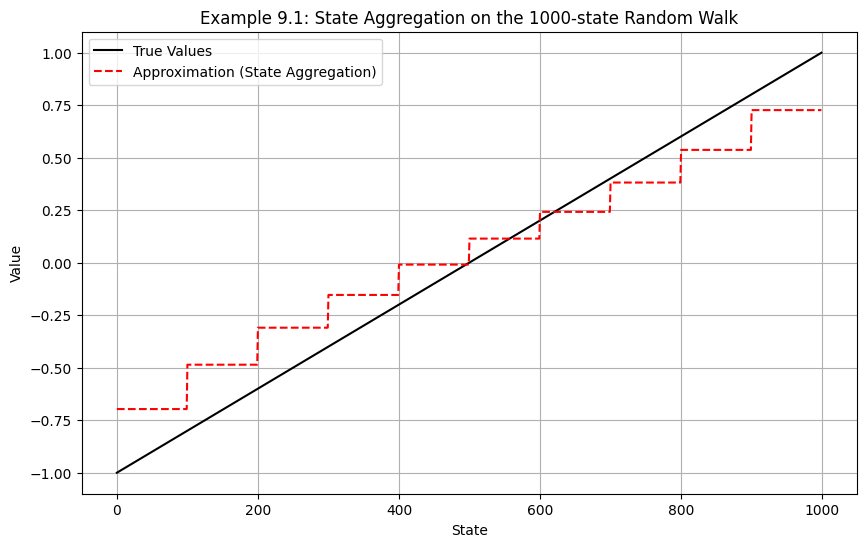

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_states = 1000
start_state = 500
neighbor_range = 100
gamma = 1.0
alpha = 2e-5
episodes = 100_000 

# State Aggregation 설정 하는 부분입니다. 이 부분이 낯설 수 있겠네요. 
n_groups = 10
group_size = n_states // n_groups
w = np.zeros(n_groups)

def get_group(state):
    return min(state // group_size, n_groups - 1)

def step_random_walk(state):
    if np.random.rand() < 0.5: # 왼쪽으로 1~100칸 중 랜덤 이동하거나,
        step = np.random.randint(1, neighbor_range + 1)
        next_state = state - step
        if next_state < 0:
            return None, -1, True
        else:
            return next_state, 0, False
    else: # 오른쪽으로 1~100칸 중 랜덤 이동합니다. 
        step = np.random.randint(1, neighbor_range + 1)
        next_state = state + step
        if next_state >= n_states:
            return None, +1, True
        else:
            return next_state, 0, False

# TD(0)입니다. 간단하죠?
for ep in range(episodes):
    s = start_state
    done = False
    while not done:
        ns, r, done = step_random_walk(s)
        g = get_group(s)
        if done:
            target = r
        else:
            target = r + gamma * w[get_group(ns)]
        w[g] += alpha * (target - w[g])
        if not done:
            s = ns

# V(s)를 근사합니다. 
V_hat = np.zeros(n_states)
for s in range(n_states):
    V_hat[s] = w[get_group(s)]

# 교재 Figure 9.1의 True Values 를 계산합니다.
true_values = np.linspace(-1, 1, n_states)

plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', color='black')
plt.plot(V_hat, label='Approximation (State Aggregation)', linestyle='--', color='red')
plt.xlabel("State")
plt.ylabel("Value")
plt.title("Example 9.1: State Aggregation on the 1000-state Random Walk")
plt.legend()
plt.grid(True)
plt.show()

# 2. Exercise 6.5: Windy Gridworld 

지난 번 풀어본 문제를 FA로 풀어 봅시다. 

## 2.1. Problem Definition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


GRID_HEIGHT = 7
GRID_WIDTH = 10

WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

START_STATE = (3, 0)
GOAL_STATE = (3, 7)

ACTIONS_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
ACTIONS_8 = ACTIONS_4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
ACTIONS_9 = ACTIONS_8 + [(0, 0)]

ALPHA = 0.5
EPSILON = 0.1
GAMMA = 1.0

REWARD_PER_STEP = -1
REWARD_GOAL = 0

def env_step_stochastic_wind(state, action_idx, current_actions):
    y, x = state
    dy, dx = current_actions[action_idx]

    next_y_after_action = y + dy
    next_x_after_action = x + dx

    final_next_y = next_y_after_action
    final_next_x = next_x_after_action

    if 0 <= final_next_x < GRID_WIDTH:
        mean_wind_effect = WIND[final_next_x]
        
        rand_val = np.random.rand()
        if rand_val < 1/3:
            stochastic_wind_effect = mean_wind_effect - 1
        elif rand_val < 2/3:
            stochastic_wind_effect = mean_wind_effect
        else:
            stochastic_wind_effect = mean_wind_effect + 1
        
        final_next_y -= stochastic_wind_effect

    final_next_y = max(0, min(final_next_y, GRID_HEIGHT - 1))
    final_next_x = max(0, min(final_next_x, GRID_WIDTH - 1))

    next_state = (final_next_y, final_next_x)

    reward = REWARD_PER_STEP
    if next_state == GOAL_STATE:
        reward = REWARD_GOAL       

    return next_state, reward

def plot_results(results, labels, title, x_limit=8000):
    plt.figure(figsize=(12, 6))
    
    for i, res in enumerate(results):
        cumulative_steps = np.cumsum(res)
        episodes_within_limit = np.sum(cumulative_steps <= x_limit)
        
        plt.plot(cumulative_steps[:episodes_within_limit], np.arange(1, episodes_within_limit + 1), label=labels[i])
    
    plt.xlabel('Time Steps (Total Steps)')
    plt.ylabel('Episodes')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(0, x_limit)
    plt.show()

def plot_trajectory(Q, actions_set, start_state, goal_state, title="Optimal Trajectory"):
    plt.figure(figsize=(GRID_WIDTH, GRID_HEIGHT + 1.0))
    
    plt.imshow(np.zeros((GRID_HEIGHT, GRID_WIDTH)), cmap='bone_r', origin='upper', 
               extent=[-0.5, GRID_WIDTH-0.5, GRID_HEIGHT-0.5, -0.5]) 
    
    for x in range(GRID_WIDTH):
        if WIND[x] > 0:
            plt.arrow(x, GRID_HEIGHT - 0.5, 0, -0.4 * WIND[x], color='blue', head_width=0.2, head_length=0.2, alpha=0.6)
            plt.text(x, GRID_HEIGHT + 0.2, str(WIND[x]), color='blue', ha='center', va='top', fontsize=10)

    plt.text(start_state[1], start_state[0], 'S', color='green', ha='center', va='center', fontsize=12, weight='bold')
    plt.text(goal_state[1], goal_state[0], 'G', color='red', ha='center', va='center', fontsize=12, weight='bold')
    plt.hlines(y=np.arange(-0.5, GRID_HEIGHT), xmin=-0.5, xmax=GRID_WIDTH-0.5, color='black', linewidth=0.5)
    plt.vlines(x=np.arange(-0.5, GRID_WIDTH), ymin=-0.5, ymax=GRID_HEIGHT-0.5, color='black', linewidth=0.5)
    plt.xticks([]) 
    plt.yticks([]) 
    
    path_x = [start_state[1]]
    path_y = [start_state[0]]

    max_steps = 1000 
    current_iter_state = START_STATE
    
    visited_states = set() 

    for step_count in range(max_steps): 
        if current_iter_state == GOAL_STATE:
            break
        if current_iter_state in visited_states: 
            break
        visited_states.add(current_iter_state)

        y, x = current_iter_state
        best_action_idx = np.argmax(Q[y, x, :])
        dy, dx = actions_set[best_action_idx]
        
        next_y_unwind = y + dy
        next_x_unwind = x + dx

        next_y_winded = next_y_unwind
        if 0 <= next_x_unwind < GRID_WIDTH:
            next_y_winded -= WIND[next_x_unwind]

        final_next_y = max(0, min(next_y_winded, GRID_HEIGHT - 1))
        final_next_x = max(0, min(next_x_unwind, GRID_WIDTH - 1))
        

        plt.plot([current_iter_state[1], final_next_x], [current_iter_state[0], final_next_y], 'r-o', markersize=3, linewidth=1)
        
        current_iter_state = (final_next_y, final_next_x)
        path_x.append(current_iter_state[1])
        path_y.append(current_iter_state[0])
    
    plt.plot(path_x, path_y, 'r-', linewidth=2, marker='o', markersize=4)

    plt.title(title)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

## 2.2. Linear FA

### 2.2.1. Parameter-linear Model
Linear FA 코드입니다. 우선 모델이 parameter에 대해 선형입니다. '선형'이라는 표현이 혼란스러울 수 있어요. Parameter에 대해 선형이라는 말은 아래와 같이 표현합니다. 

$Q(s, a) = \mathbf{w}_a^\top \mathbf{x}(s)$

매개변수는 $W$이며, 좀 더 풀어 쓰면 다음과 같습니다. 좀 더 '선형'이라는 표현이 와 닿나요?

$Q(s,a) = w_{a,0} + w_{a,1}x_1 + w_{a,2}x_2 + \dots + w_{a,n}x_n$

그리고 feature 도 선형으로 표현합니다. Feature 는 $x$죠? Feature 는 

Sarsa(0) Linear FA: 100%|██████████| 80000/80000 [13:57<00:00, 95.51it/s] 


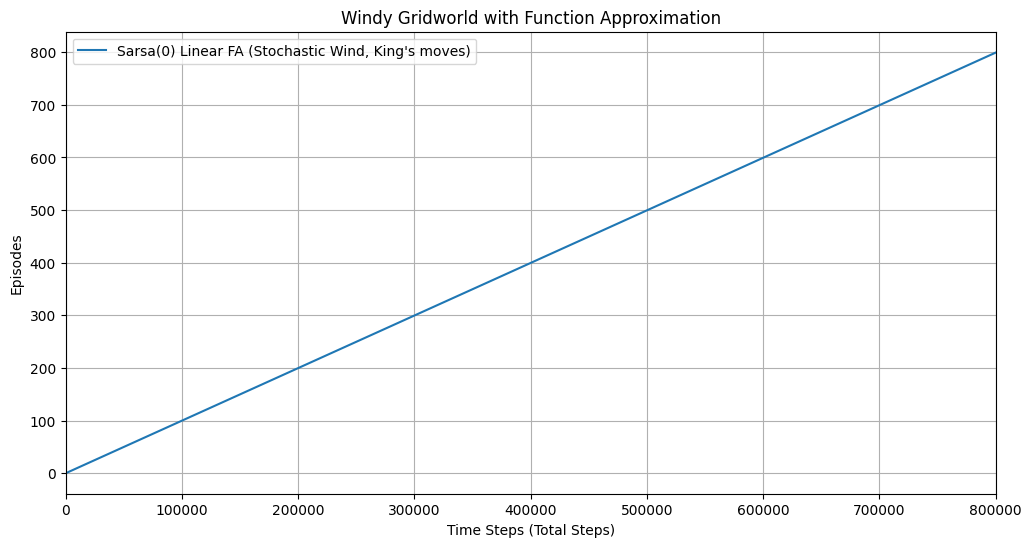

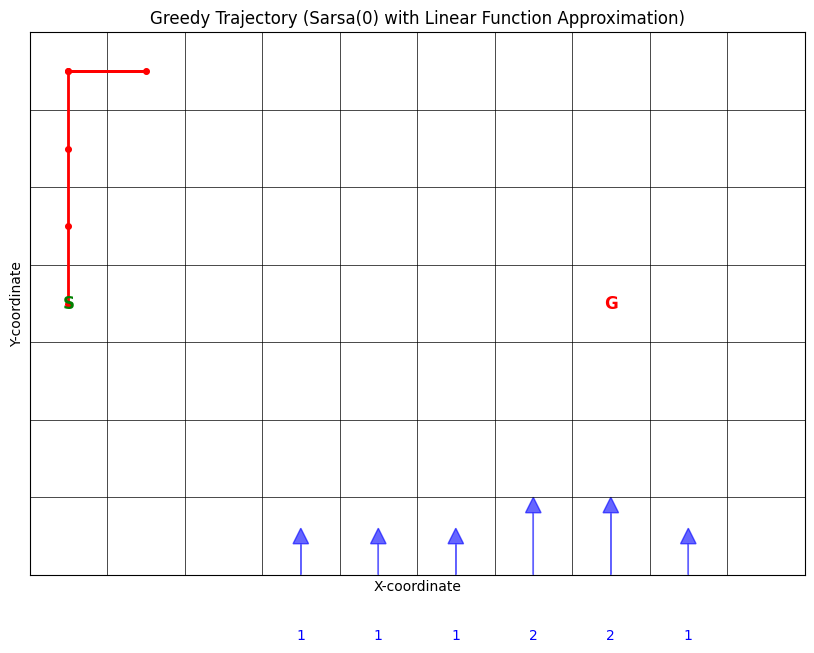

In [ ]:
import numpy as np

np.random.seed(42)

class LinearQFA:
    def __init__(self, n_actions, n_features):
        self.W = np.zeros((n_actions, n_features))

    def features(self, state):
        y, x = state
        y_n = y / (GRID_HEIGHT - 1)
        x_n = x / (GRID_WIDTH - 1)
        wind_mean = WIND[x] / max(1, max(WIND))
        return np.array([1.0, y_n, x_n, wind_mean])

    def q_value(self, state, action_idx):
        x = self.features(state)
        return np.dot(self.W[action_idx], x)

    def q_values(self, state):
        x = self.features(state)
        return self.W @ x

    def update(self, state, action_idx, target, alpha):
        x = self.features(state)
        prediction = np.dot(self.W[action_idx], x)
        td_error = target - prediction
        self.W[action_idx] += alpha * td_error * x

def epsilon_greedy(Q, state, epsilon, actions_set):
    if np.random.rand() < epsilon:
        return np.random.randint(len(actions_set))
    q_vals = Q.q_values(state)
    return np.argmax(q_vals)

def sarsa_linear_fa(num_episodes, actions_set):
    Q = LinearQFA(len(actions_set), 4)
    steps_per_episode = []

    for ep in tqdm(range(num_episodes), desc="Sarsa(0) Linear FA"):
        state = START_STATE
        action_idx = epsilon_greedy(Q, state, EPSILON, actions_set)
        step_count = 0

        while True:
            next_state, reward = env_step_stochastic_wind(state, action_idx, actions_set)
            step_count += 1

            if next_state == GOAL_STATE:
                target = reward
                Q.update(state, action_idx, target, ALPHA)
                break
            else:
                next_action_idx = epsilon_greedy(Q, next_state, EPSILON, actions_set)
                target = reward + GAMMA * Q.q_value(next_state, next_action_idx)
                Q.update(state, action_idx, target, ALPHA)

            state = next_state
            action_idx = next_action_idx

            if step_count > 1000:  # 안전 제한
                break

        steps_per_episode.append(step_count)

    return Q, steps_per_episode

# 학습 실행
NUM_EPISODES = 8000
Q_linear_fa, steps_linear_fa = sarsa_linear_fa(NUM_EPISODES, ACTIONS_8)

# 학습 결과 시각화
plot_results([steps_linear_fa], ["Sarsa(0) Linear FA (Stochastic Wind, King's moves)"],
             "Windy Gridworld with Function Approximation", x_limit=NUM_EPISODES * 10)

# 최적 경로 시각화
plot_trajectory(np.stack([Q_linear_fa.q_values((y,x)) for y in range(GRID_HEIGHT) for x in range(GRID_WIDTH)]).reshape(GRID_HEIGHT, GRID_WIDTH, -1),
                ACTIONS_8, START_STATE, GOAL_STATE,
                "Greedy Trajectory (Sarsa(0) with Linear Function Approximation)")

### 2.2.2. Input-nonlinear



Sarsa(0) Linear FA: 100%|██████████| 80000/80000 [07:24<00:00, 180.17it/s]


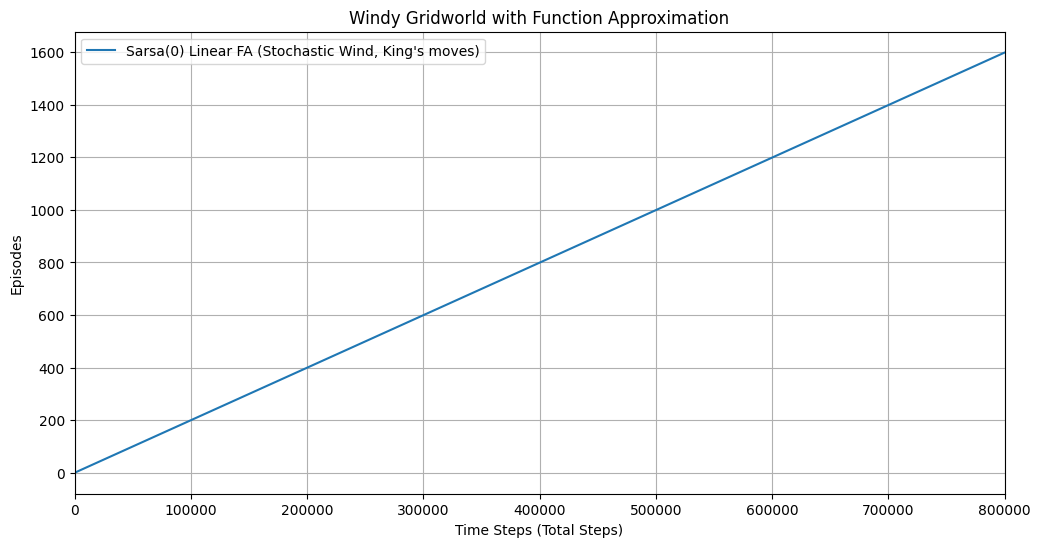

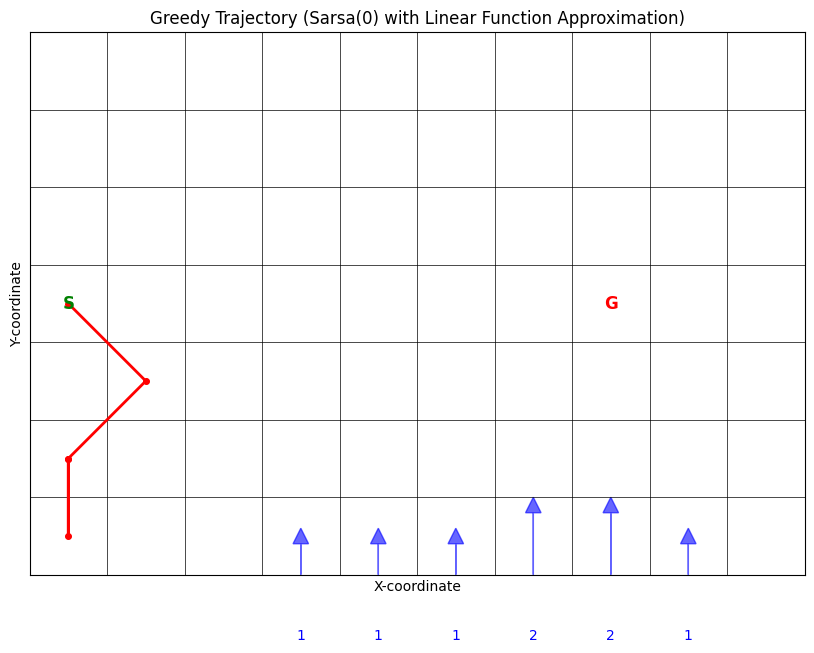

In [ ]:
import numpy as np

np.random.seed(42)

class LinearQFA:
    def __init__(self, n_actions, n_features):
        self.W = np.zeros((n_actions, n_features))

    def features(self, state):
        y, x = state
        y_n = y / (GRID_HEIGHT - 1)
        x_n = x / (GRID_WIDTH - 1)
        wind_mean = WIND[x] / max(1, max(WIND))
        # 2차 확장 feature 를 정의합니다. 
        return np.array([1.0, y_n, x_n, y_n*x_n, y_n**2, x_n**2, wind_mean])

    def q_value(self, state, action_idx):
        return np.dot(self.W[action_idx], self.features(state))

    def q_values(self, state):
        return self.W @ self.features(state)

    def update(self, state, action_idx, target, alpha):
        x = self.features(state)
        prediction = np.dot(self.W[action_idx], x)
        td_error = target - prediction
        self.W[action_idx] += alpha * td_error * x

def sarsa_linear_fa(num_episodes, actions_set):
    Q = LinearQFA(len(actions_set), 7)
    steps_per_episode = []
    alpha = 0.05        # 학습률도 조정해 보세요.
    epsilon = 0.1

    for ep in tqdm(range(num_episodes), desc="Sarsa(0) Linear FA"):
        state = START_STATE
        action_idx = epsilon_greedy(Q, state, epsilon, actions_set)
        step_count = 0

        while True:
            next_state, reward = env_step_stochastic_wind(state, action_idx, actions_set)
            step_count += 1

            if next_state == GOAL_STATE:
                Q.update(state, action_idx, reward, alpha)
                break
            else:
                next_action_idx = epsilon_greedy(Q, next_state, epsilon, actions_set)
                target = reward + GAMMA * Q.q_value(next_state, next_action_idx)
                Q.update(state, action_idx, target, alpha)

            state = next_state
            action_idx = next_action_idx

            if step_count > 500:
                break

        steps_per_episode.append(step_count)

    return Q, steps_per_episode

NUM_EPISODES = 8000
Q_linear_fa, steps_linear_fa = sarsa_linear_fa(NUM_EPISODES, ACTIONS_8)

plot_results([steps_linear_fa], ["Sarsa(0) Linear FA (Stochastic Wind, King's moves)"],
             "Windy Gridworld with Function Approximation", x_limit=NUM_EPISODES * 10)

plot_trajectory(np.stack([Q_linear_fa.q_values((y,x)) for y in range(GRID_HEIGHT) for x in range(GRID_WIDTH)]).reshape(GRID_HEIGHT, GRID_WIDTH, -1),
                ACTIONS_8, START_STATE, GOAL_STATE,
                "Greedy Trajectory (Sarsa(0) with Linear Function Approximation)")

### 2.2.3.Tile coding
Tile coding 을 사용해 봅니다. Sarsa 를 expected Sarsa 로 변환했어요. 왜 expected Sarsa 로 변환했는지는 직접 Q-learning 과 비교하며 이해해 보세요. 

Tile coding이 처음에는 무슨 짓을 하고 있는 것인지 이해하기가 어렵습니다. 이해를 돕기 위해 예를 하나 설명합니다. 

예:
1. state: 현재 에이전트가 state = (3, 2)에 있다고 가정해 봅시다. (Y=3, X=2)
2. action_idx: ACTIONS_8 리스트에서 action_idx = 0이 (-1, 0) (위로 한 칸 이동)이라고 가정합시다.
3. 지금 코드에서는 8개의 타일링을 사용하고 있고(n_tilings = 8), 각 타일링이 상태 공간을 8행, 8열 타일로 나누고 있습니다(tiles = (8, 8). 따라서,
  - self.tile_width = (GRID_HEIGHT / tiles[0], GRID_WIDTH / tiles[1])
    - self.tile_width = (7 / 8, 10 / 8) = (0.875, 1.25)
    - 각 타일링에서 타일 하나의 실제 공간적 너비(높이, 폭)입니다.
  - self.n_features = n_tilings * tiles[0] * tiles[1] = 8 * 8 * 8 = 512
    - 총 512개의 특징(가중치)이 존재합니다. self.W 행렬의 두 번째 차원 크기입니다.

**단계 1: tile_coder.get_features(state) 호출하여 indices 얻기**

TileCoder의 get_features((3, 2))가 어떻게 작동하는지 보겠습니다. y = 3, x = 2 입니다.

각 tiling_idx (0부터 7까지)에 대해 offsets가 다르게 적용되어 타일 인덱스가 계산됩니다.

  - Tiling 0 (tiling_idx = 0): off_y = 0, off_x = 0
    - tile_y = int((3 + 0) / 0.875) = int(3 / 0.875) = int(3.428...) = 3
    - tile_x = int((2 + 0) / 1.25) = int(2 / 1.25) = int(1.6) = 1
    - index = 0 * (8*8) + 3 * 8 + 1 = 25 (첫 번째 타일링에서 (3, 1) 타일)
  - Tiling 1 (tiling_idx = 1): off_y = 0.875 / 8 = 0.109375, off_x = 1.25 / 8 = 0.15625
    - tile_y = int((3 + 0.109375) / 0.875) = int(3.109375 / 0.875) = int(3.553...) = 3
    - tile_x = int((2 + 0.15625) / 1.25) = int(2.15625 / 1.25) = int(1.725) = 1
    - index = 1 * (8*8) + 3 * 8 + 1 = 64 + 24 + 1 = 89 (두 번째 타일링에서 (3, 1) 타일)
이런 식으로 n_tilings (8개) 만큼 계산이 이루어져 8개의 인덱스가 features 리스트에 추가됩니다.

예를 들어, get_features((3, 2))의 결과로 다음과 같은 indices가 반환되었다고 가정해 봅시다:
  - indices = [25, 89, 153, 217, 281, 345, 409, 473](실제 계산 값은 다를 수 있으며, 이는 offsets의 정확한 값에 따라 달라집니다.)

**단계 2: LinearQ_TileCoding의 q_value 또는 q_values 메서드에서 np.sum(self.W[action_idx, indices]) 연산**

action_idx = 0 (위로 이동) 이므로, q_value(state, 0)를 계산한다고 가정합시다.

self.W는 (n_actions, n_features) 형태를 가집니다. n_actions는 len(ACTIONS_8)로 8이고, n_features는 512입니다. 따라서 self.W는 (8, 512) 크기의 배열입니다.

self.W[action_idx, indices]는 self.W[0, [25, 89, 153, 217, 281, 345, 409, 473]]가 됩니다. 이는 self.W 행렬의 0번째 행에서, indices 리스트에 있는 열 인덱스에 해당하는 값들을 모두 선택한다는 의미입니다.

이 결과로 다음과 같은 1차원 배열이 생성됩니다.
  - [W[0, 25], W[0, 89], W[0, 153], W[0, 217], W[0, 281], W[0, 345], W[0, 409], W[0, 473]]

마지막으로 np.sum(...)은 이 배열의 모든 원소들을 합산합니다. 왜냐면 우리는 지금 linear function approximation를 배우고 있기 때문입니다. 
  - Q((3, 2), 위로 이동) = W[0, 25] + W[0, 89] + W[0, 153] + W[0, 217] + W[0, 281] + W[0, 345] + W[0, 409] + W[0, 473]

이 합산된 값이 바로 state=(3, 2)에서 action_idx=0 (위로 이동)을 수행했을 때의 Q-값 추정치입니다.

Expected Sarsa with Tile Coding: 100%|██████████| 8000/8000 [00:23<00:00, 342.36it/s]


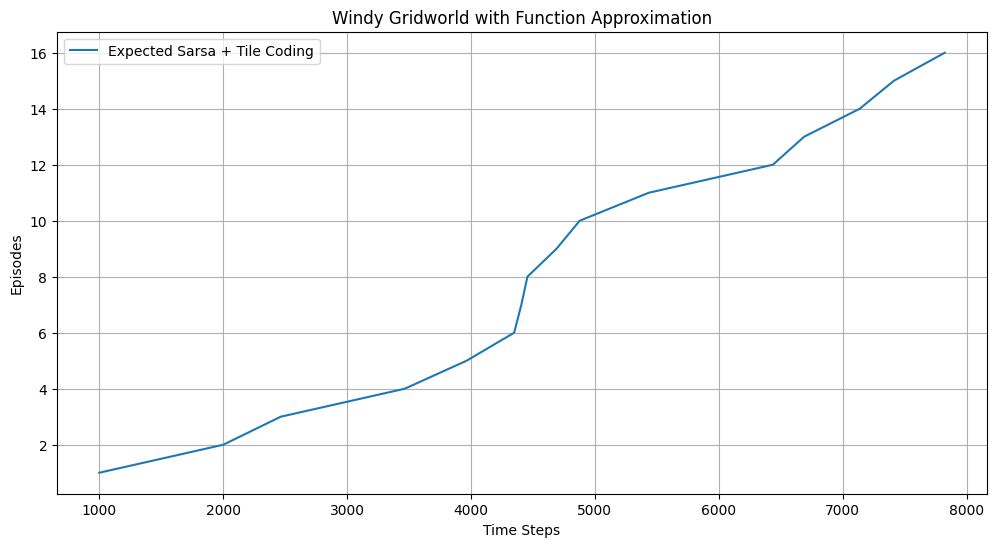

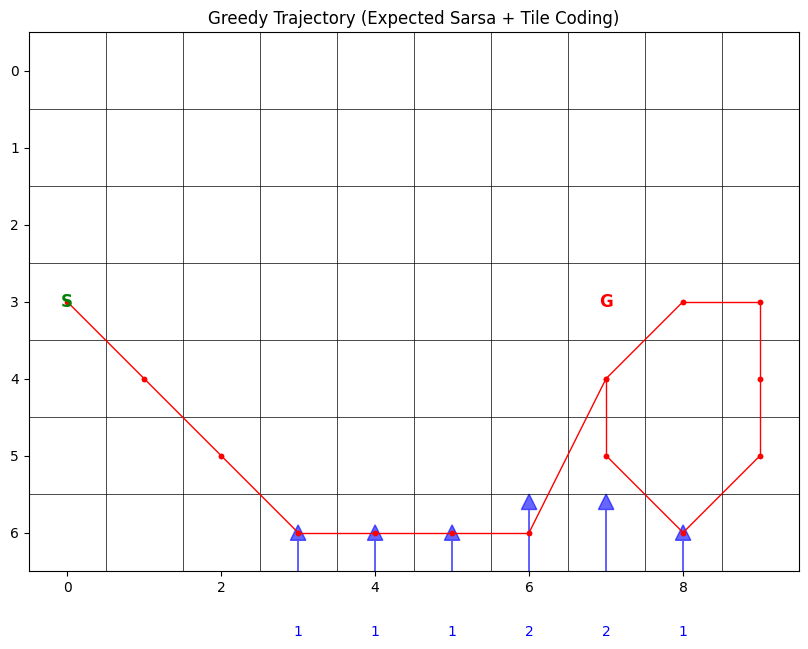

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class TileCoder:
    def __init__(self, n_tilings=8, tiles=(8, 8)):
        self.n_tilings = n_tilings
        self.tiles = tiles
        self.tile_width = (GRID_HEIGHT / tiles[0], GRID_WIDTH / tiles[1])
        self.offsets = [
            (i * self.tile_width[0] / n_tilings, i * self.tile_width[1] / n_tilings)
            for i in range(n_tilings)
        ]

    def get_features(self, state):
        y, x = state
        features = []
        for tiling_idx, (off_y, off_x) in enumerate(self.offsets):
            tile_y = int((y + off_y) / self.tile_width[0])
            tile_x = int((x + off_x) / self.tile_width[1])
            
            tile_y = min(tile_y, self.tiles[0] - 1)
            tile_x = min(tile_x, self.tiles[1] - 1)
            
            index = tiling_idx * self.tiles[0] * self.tiles[1] + tile_y * self.tiles[1] + tile_x
            features.append(index)
        return features

class LinearQ_TileCoding:
    def __init__(self, n_actions, tile_coder):
        self.n_actions = n_actions
        self.tile_coder = tile_coder
        self.n_features = tile_coder.n_tilings * np.prod(tile_coder.tiles)
        self.W = np.zeros((n_actions, self.n_features))

    def q_value(self, state, action_idx):
        indices = self.tile_coder.get_features(state)
        return np.sum(self.W[action_idx, indices])

    def q_values(self, state):
        indices = self.tile_coder.get_features(state)
        return np.sum(self.W[:, indices], axis=1)

    def update(self, state, action_idx, target, alpha):
        indices = self.tile_coder.get_features(state)
        prediction = np.sum(self.W[action_idx, indices])
        td_error = target - prediction
        self.W[action_idx, indices] += (alpha / self.tile_coder.n_tilings) * td_error

def epsilon_greedy(Q, state, epsilon, actions):
    if np.random.rand() < epsilon:
        return np.random.randint(len(actions))
    return np.argmax(Q.q_values(state))

def expected_sarsa_tilecoding(num_episodes, actions):
    """ 
    Expected Sarsa 로 변경합니다. 
    """
    tile_coder = TileCoder(n_tilings=8, tiles=(8, 8))
    Q = LinearQ_TileCoding(len(actions), tile_coder)
    steps_per_episode = []

    for ep in tqdm(range(num_episodes), desc="Expected Sarsa with Tile Coding"):
        state = START_STATE
        step_count = 0

        while True:
            action_idx = epsilon_greedy(Q, state, EPSILON, actions)
            next_state, reward = env_step_stochastic_wind(state, action_idx, actions)
            step_count += 1

            if next_state == GOAL_STATE:
                Q.update(state, action_idx, reward, ALPHA)
                break

            q_next = Q.q_values(next_state)
            greedy_action = np.argmax(q_next)
            
            expected_value = (
                (1 - EPSILON) * q_next[greedy_action]
                + (EPSILON / len(actions)) * np.sum(q_next)
            )

            target = reward + GAMMA * expected_value
            Q.update(state, action_idx, target, ALPHA)
            state = next_state

            if step_count > 1000:
                break

        steps_per_episode.append(step_count)

    return Q, steps_per_episode

NUM_EPISODES = 8000
Q_tile, steps_tile = expected_sarsa_tilecoding(NUM_EPISODES, ACTIONS_8)

def plot_results(results, labels, title):
    plt.figure(figsize=(12, 6))
    for res, label in zip(results, labels):
        cumulative_steps = np.cumsum(res)
        episodes_within_limit = np.sum(cumulative_steps <= 8000)
        plt.plot(cumulative_steps[:episodes_within_limit], np.arange(1, episodes_within_limit + 1), label=label)
    plt.xlabel('Time Steps')
    plt.ylabel('Episodes')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results([steps_tile], ["Expected Sarsa + Tile Coding"], "Windy Gridworld with Function Approximation")

def plot_greedy_trajectory(Q, actions, start, goal, title="Greedy Trajectory"):
    plt.figure(figsize=(10, 7))
    plt.imshow(np.zeros((GRID_HEIGHT, GRID_WIDTH)), cmap='bone_r', origin='upper', extent=[-0.5, GRID_WIDTH-0.5, GRID_HEIGHT-0.5, -0.5])
    for x in range(GRID_WIDTH):
        if WIND[x] > 0:
            plt.arrow(x, GRID_HEIGHT - 0.5, 0, -0.4 * WIND[x], color='blue', head_width=0.2, head_length=0.2, alpha=0.6)
            plt.text(x, GRID_HEIGHT + 0.2, str(WIND[x]), color='blue', ha='center', va='top', fontsize=10)
    plt.text(start[1], start[0], 'S', color='green', ha='center', va='center', fontsize=12, weight='bold')
    plt.text(goal[1], goal[0], 'G', color='red', ha='center', va='center', fontsize=12, weight='bold')
    plt.hlines(np.arange(-0.5, GRID_HEIGHT), -0.5, GRID_WIDTH-0.5, color='black', linewidth=0.5)
    plt.vlines(np.arange(-0.5, GRID_WIDTH), -0.5, GRID_HEIGHT-0.5, color='black', linewidth=0.5)

    state = start
    path = [state]
    visited = set()
    for _ in range(500):
        if state == goal or state in visited:
            break
        visited.add(state)
        q_vals = Q.q_values(state)
        action_idx = np.argmax(q_vals)
        y, x = state
        dy, dx = actions[action_idx]
        ny, nx = y + dy - WIND[x], x + dx
        ny = np.clip(ny, 0, GRID_HEIGHT - 1)
        nx = np.clip(nx, 0, GRID_WIDTH - 1)
        plt.plot([x, nx], [y, ny], 'r-o', markersize=3, linewidth=1)
        state = (ny, nx)
        path.append(state)
    plt.title(title)
    plt.show()

plot_greedy_trajectory(Q_tile, ACTIONS_8, START_STATE, GOAL_STATE, "Greedy Trajectory (Expected Sarsa + Tile Coding)")

# 3. Example 10.1 Mountain Car Task 

## 3.1. Problem Definition
문제의 정의를 잘 읽고, 문제를 그대로 구현을 합니다. 

In [1]:
import numpy as np

class MountainCarEnv:
    def __init__(self, seed: int | None = None):
        self.x_min, self.x_max = -1.2, 0.5
        self.v_min, self.v_max = -0.07, 0.07
        self.goal_x = 0.5
        self.actions = np.array([-1, 0, +1], dtype=int)  # a ∈ {-1,0,+1}
        self.r_step = -1.0
        self._rng = np.random.RandomState(seed)
        self.state = None  # (x, v)

    def reset(self):
        x0 = self._rng.uniform(-0.6, -0.4)
        v0 = 0.0
        self.state = np.array([x0, v0], dtype=float)
        return self.state.copy()

    def step(self, a_idx: int):
        assert 0 <= a_idx < len(self.actions), "Invalid action index"
        a = float(self.actions[a_idx])

        x, v = self.state
        v_next = v + 0.001 * a - 0.0025 * np.cos(3.0 * x)
        v_next = np.clip(v_next, self.v_min, self.v_max)
        x_next = x + v_next

        if x_next < self.x_min:
            x_next = self.x_min
            v_next = 0.0

        done = x_next >= self.goal_x
        reward = 0.0 if done else self.r_step

        self.state = np.array([x_next, v_next], dtype=float)
        return self.state.copy(), reward, done, {}

    @property
    def n_actions(self) -> int:
        return len(self.actions)

    def sample_action(self) -> int:
        return int(self._rng.randint(self.n_actions))

# 나중에 어차피 쓸 epsilon greedy 함수입니다.
def epsilon_greedy(q_values: np.ndarray, epsilon: float, rng: np.random.RandomState) -> int:
    """
    q_values: shape (n_actions,)
    """
    if rng.rand() < epsilon:
        return int(rng.randint(q_values.shape[0]))
    max_as = np.flatnonzero(q_values == q_values.max())
    return int(rng.choice(max_as))

## 3.2. Episodic Semi-gradient Sarsa for Estimating $\hat{q} \approx q_*$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

class TileCoder:
    def __init__(self, n_tilings=8, tiles=(8, 8), limits=((-1.2, 0.5), (-0.07, 0.07))):
        self.n_tilings = n_tilings
        self.tiles = tiles
        self.limits = limits
        self.tile_width = [(limits[dim][1]-limits[dim][0]) / (tiles[dim]-1) for dim in range(2)]
        self.offsets = [
            (i * self.tile_width[0] / n_tilings, i * self.tile_width[1] / n_tilings)
            for i in range(n_tilings)
        ]

    def get_features(self, state):
        x, v = state
        features = []
        for t, (ox, ov) in enumerate(self.offsets):
            tx = int((x - self.limits[0][0] + ox) / self.tile_width[0])
            tv = int((v - self.limits[1][0] + ov) / self.tile_width[1])
            tx = min(tx, self.tiles[0]-1)
            tv = min(tv, self.tiles[1]-1)
            idx = t * self.tiles[0]*self.tiles[1] + tx*self.tiles[1] + tv
            features.append(idx)
        return features

class LinearQ_Tile:
    def __init__(self, n_actions, tile_coder):
        self.n_actions = n_actions
        self.tc = tile_coder
        self.n_features = tile_coder.n_tilings * np.prod(tile_coder.tiles)
        self.W = np.zeros((n_actions, self.n_features))

    def q_value(self, s, a):
        idxs = self.tc.get_features(s)
        return np.sum(self.W[a, idxs])

    def q_values(self, s):
        idxs = self.tc.get_features(s)
        return np.sum(self.W[:, idxs], axis=1)

    def update(self, s, a, td_error, alpha):
        idxs = self.tc.get_features(s)
        self.W[a, idxs] += (alpha / self.tc.n_tilings) * td_error

def semi_grad_sarsa(env, episodes=100, alpha=0.1, gamma=1.0, epsilon=0.1):
    tc = TileCoder()
    Q = LinearQ_Tile(env.n_actions, tc)
    rewards = []

    for ep in tqdm(range(1, episodes+1), desc="Training"):
        s = env.reset()
        a = epsilon_greedy(Q.q_values(s), epsilon, env._rng)
        total_r = 0

        while True:
            s2, r, done, _ = env.step(a)
            total_r += r
            if done:
                td_error = r - Q.q_value(s, a)
                Q.update(s, a, td_error, alpha)
                break
            else:
                a2 = epsilon_greedy(Q.q_values(s2), epsilon, env._rng)
                td_error = r + gamma * Q.q_value(s2, a2) - Q.q_value(s, a)
                Q.update(s, a, td_error, alpha)
                s, a = s2, a2

        rewards.append(total_r)
        if ep in [10, 20, 100]:
            plot_value_surface(Q, ep)

    return Q, rewards

# --- Plot value surface ---
def plot_value_surface(Q, episode):
    X = np.linspace(-1.2, 0.5, 40)
    V = np.linspace(-0.07, 0.07, 40)
    Z = np.zeros((len(X), len(V)))
    for i, x in enumerate(X):
        for j, v in enumerate(V):
            s = (x, v)
            Z[i, j] = -np.max(Q.q_values(s))

    Xg, Vg = np.meshgrid(V, X)
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(Xg, Vg, Z, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_xlabel("Velocity")
    ax.set_ylabel("Position")
    ax.set_zlabel("-max Q(s,a)")
    ax.set_title(f"Episode {episode}: -max_a q̂(s,a;w)")
    fig.colorbar(surf, shrink=0.6)
    plt.show()

env = MountainCarEnv(seed=1)
Q_learned, rewards = semi_grad_sarsa(env, episodes=100, alpha=0.1, gamma=1.0, epsilon=0.1)

: 